# Overview



## Introduction to functional magnetic resonance imaging (fMRI)

In this session, we will learn about fMRI data properties by loading, manipulating and visualizing it.

# Goals for today

We will go over some important concepts of data manipulation and visualization in fMRI, including: 

* Displaying a data (functional volumes) as an image (`plt.imshow()`)
* Selecting an appropriate colormap for data visualization
* Displaying a 3D array as a mosaic or contact sheet of images
* Plotting timecourses of fMRI data
* Masking / unmasking of fMRI data

By the end, we will have written functions to:

* Display a 3D array as a mosaic of images
* Unmask an array
* Normalize a timeseries

## Short overview of fMRI 

Functional Magnetic Resonance Imaging, or fMRI, is a measure of brain activity over time. FMRI data is acquired using a special pulse sequence designed to measure changes in the magnetic properties of the blood flow using the Magnetic Resonance Imaging (MRI) scanner.

<img src="figures/mri_scanner.png" style="height: 400px;">

The functional signal we measure with fMRI is *not* an electrical neural signal (as in EEG, ECoG, or electrophysiology). It is a magnetic signal related to the properties of brain tissue, and it is dominated by blood flow. Blood flow is related to neural activity, because firing neurons need oxygen. The process of firing involves letting electrically charged ions into a cell and actively pumping them back out again, which is metabolically demanding. So once a region of the brain becomes active (once the neurons start firing), metabolism in that region is high, oxygen gets stripped off of hemoglobin molecules in red blood cells in the area (thereby changing the magnetic properties of hemoglobin, creating a deoxyhemoglobin). This initiates a complex process to increase blood flow to the electrically active area. 

<img src="figures/deoxyhemoglobin.png" style="height: 400px;">


The specific mechanisms that lead from neural activity to changes in blood flow are (a) not well understood, and (b) beyond the scope of this class. For now, just know that there are several ways to measure functional responses with MRI, and the specific one that we work with is the Blood Oxygenation Level Dependent Response, or the BOLD response. 

### fMRI has high spatial but low temporal resolution

We have belabored this here a little because this complexity should always be a source of humility for anyone working with fMRI or trying to interpret fMRI results. It is an **indirect, slow measure** - and these considerations strongly constrain the kinds of experiments you can do with fMRI and the conclusions you can draw from those experiments.

An important practical upshot of this for our purposes is that the signal we measure changes much more slowly than the signal we measure in EEG or ECoG. Responses emerge over seconds, not milliseconds.

<img src="figures/imaging_modalities.png" style="height: 400px;">

                                      Sejnowski et al., Nature Neurosci., 2014




One fMRI image (fMRI volume) is acquired for a given unit of time called a repetition time (TR). A TR is typically 1-2 seconds *(usually 1.0, 1.5, or 2.0 seconds)*. Every image records the activity in the brain at a given point in time. The following image shows a single volume of fMRI data (one two-second snapshot of brain activity).

<img src="figures/fig1.png" style="height: 400px;">

The dimensions of the brain volume measured by fMRI can vary. Each individual fMRI measurement unit is called a *voxel*, which is short for volumetric pixel. The voxels in this data are about 2.4 x 2.4 x 4.0 mm (X x Y x Z) in size. 

### FMRI activity in time

Once a neural event is triggered by a stimulus presentation the vascular system needs to respond to the need for glucose and oxygen in that specific brain area. This can take up to 1-2 seconds. Hence the hemodynamic response lags the triggered event by 1-2 seconds, which peaks around 5 seconds after the stimulus onset.

<img src="figures/lagged_activity.png" style="height: 400px;">

### Example fMRI experiments 

#### Viewing natural images 

<img src="figures/fmri_example_experiment.png" style="height: 400px;">

#### Fusiform Face Area (FFA)

<img src="figures/ffa.png" style="height: 400px;">



In [ ]:
### TEACHER INFO


## FMRI as a *mapping* technique
The scanning volume for the data we will use here consists of 30 transverse slices (i.e. Z is between 0 and 29). Transverse slices are horizontal, i.e., approximately parallel to the plane of the eyes and ears. Each slice corresponds to a 2D image of 100 x 100 voxels.

We can measure fMRI responses across the whole brain. Therefore fMRI can be seen as a *mapping* technique. In order to make brain maps, we have to be able to match measured voxel responses to the participant's brain anatomy. Using a different type of MRI sequence, we can collect a **structural scan** (also called **anatomical scan**), and obtain a high resolution image of a participant's brain. Here is an example:

<img src="figures/MPRAGE_wcortex.png">

Most MRI measures activity in the cerebral cortex, or the outer layer of the brain. Using automated reconstruction software (and some manual editing), it's possible to build a 3D representation of the shape of the subject's cerebral cortex:

<img src="figures/cortex_3views.png">


In further lectures, we will learn how to overlay functional data onto the high resolution cortical representation for each individual the subject, so that we can make sense of the data.


## Storing fMRI data for data analysis

We store fMRI data as a matrix. This means that each volume (a timepoint) in the experiment will correspond to a row in the matrix, and each voxel will correspond to a column in that matrix. For this reason, we need to make sure the criteria we use to move each 3D image to a matrix row is preserved and this operation is inverted. Let's look at an example.

<img src="figures/fmri_dimensions.png">


## Loading data

fMRI data is stored in a variety of formats. The medical imaging community has a standardized image format called Digital Imaging and Communications in Medicine (DICOM) to handle and store raw medical imaging data. When data is collected using the MRI scanner each volume is stored in a DICOM file that contains both a header and the image data. The DICOM header stores useful information about the participant's name, pulse sequence, the type of scan, image dimensions, etc. (Another popular medical imaging format is the Analyze format, where the image and header file are stored separately.) You can read about these file formats [here](http://people.cas.sc.edu/rorden/dicom/index.html).

Before we start analyzing the data we convert the raw DICOM files into the commonly used Neuroimaging Informatics Technology Initiative (nifti) file format. Files stored in this format usually have the extension .nii or .nii.gz. 

We will use the `nibabel` python module to load data that is stored such data formats.

In [1]:
import nibabel
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt  # for visualization

# Set defaults for matplotlib plotting in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In the following we will load one run (also referred to as a scan) worth of fMRI data that was stored as a nifti file format. 

In [2]:
# Create a nifti (nii) proxy object
#fname = '../../data/fMRI/categories/sub01_categories1_1.nii.gz'
fname = '/home/shared/cogneuro-connector/data/fmri/categories/sub01_categories1_1.nii.gz'
nii = nibabel.load(fname) 

# This object stores the infomation *about* the fMRI data stored in the file. 
# This meta-data can be accessed via attributes of the `nii` object.
print('nii.in_memory : ', nii.in_memory)
print('nii.shape : ', nii.shape)

nii.in_memory :  False
nii.shape :  (100, 100, 30, 120)


In [3]:
# Retrieve actual data as an array
data = nii.get_data()
print('nii.in_memory : ', nii.in_memory)
print('data shape : ', data.shape)

nii.in_memory :  True
data shape :  (100, 100, 30, 120)


The dimensions of the data are (X, Y, Z, T) (T is time, in TRs). Thus, there are 120 volumes (120 time points). Each volume has 30 horizontal or transverse slices with 100 x 100 pixels.

<img src="figures/slices.png" style="height: 200px;">

#### Transpose data

When we work with functional images it is in general more convenient (for reasons like averaging over time, transfering data to a standard units, etc.) to have the data in T, Z, Y, X format. This is the opposite of the conventions you've seen so far for EEG / ECoG data. 

When we worked with EEG/ECoG data in the first half of the class, time was the *last* axis; here, time is the *first* axis. The reasons for this convention will become more obvious as we go, and we see how this convention makes for convenient syntax and shortcuts. 

Hence, we will use the `transpose` function  of the numpy package (or `.T` method of numpy arrays) to make this dimensional switch.

In [5]:
# Transpose the data
print(data.shape)
dataT = np.transpose(data)

# Or, equivalently
dataT_ = data.T

print("dataT shape :", dataT.shape)
print("dataT_ shape : ", dataT_.shape)

(100, 100, 30, 120)
dataT shape : (120, 30, 100, 100)
dataT_ shape :  (120, 30, 100, 100)


#### assert function
You can check whether to variables are the same using the `assert` function.

In [6]:
a = 2 
b = 1
assert a==b

AssertionError: 

You can also append an error message. This message will be printed if the two are not equal

In [7]:
assert a==b, 'these two are not equal!'

AssertionError: these two are not equal!

### Breakout session: Explore the function transpose

> Now test whether dataT and dataT_ are the same using assert

> What does transpose do to a 2D array? To an array > 2D? How could you figure this out? 

In [9]:
# Are dataT and dataT_ the same?
### STUDENT ANSWER
assert np.all(dataT==dataT_)

In [10]:
# Pause for exploration of transpose
# First create some 2D array
x = np.array([np.arange(5), np.arange(5)+10])
print(x)


[[ 0  1  2  3  4]
 [10 11 12 13 14]]


In [11]:
# Transpose the array
### STUDENT ANSWER
print(x.T)

[[ 0 10]
 [ 1 11]
 [ 2 12]
 [ 3 13]
 [ 4 14]]


In [12]:
# Check out the function "flatten"
### STUDENT ANSWER
print(x.flatten())

[ 0  1  2  3  4 10 11 12 13 14]


In [14]:
a = np.arange(20)
print(a)

# Now reshape the array a into a 4x5 dimensional array
### STUDENT ANSWER
print(a.reshape(4, 5))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]


## Exploring the data

For fMRI, the functions we will use to explore the data are in general more basic than the functions we used in the first part of the class. We will not use a single module like MNE to make standard plots; we will construct our own!

This is a little more work, but is very generalizable to other kinds of analyses, and if you get good at it you can make exactly the plot of your data that you want.

One of the first questions about a data set (after its size) that you should explore is 

    "What is the scale (min/max) of the data?". 

Afterwards you may be interested to know its mean, standard deviation, and how in general the data looks like and make a histogram plot of the data.

In [15]:
# Keep data transposed
data = dataT

del dataT, dataT_
print(data.shape)

(120, 30, 100, 100)


In [16]:
# Find out the scale of the data
print(np.min(data), ', ', np.max(data)) 

# Find out its mean
print(np.mean(data))

# Find out its mean
print(np.std(data))

-28.1915265253 ,  2843.43579235
192.02111475
344.510302536


(120, 30, 100, 100)
[  0.           5.12470758  11.00099354   1.34162263   7.27446371
  16.25841349   8.80028226  10.82020729   5.34590164   9.50756447]


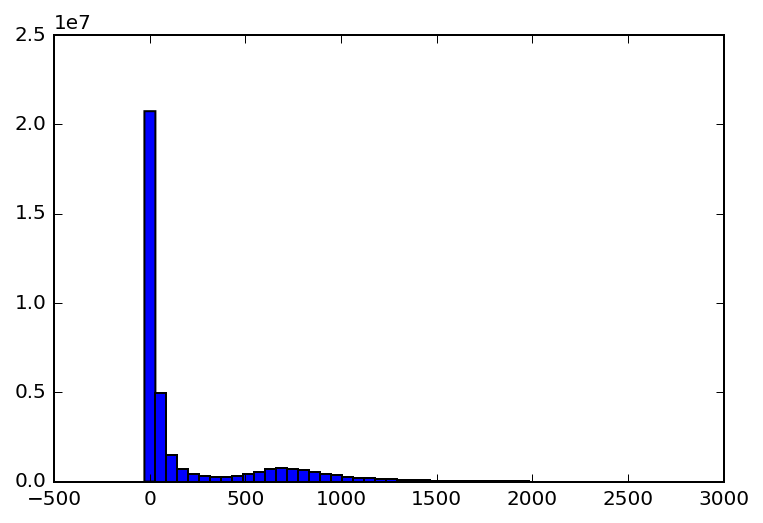

In [17]:
# Make a histogram of the data
print(data.shape)
print(data.flatten()[:10])
_ = plt.hist(data.flatten(), bins=50)

### Breakout session:

> - What does this tell you about the data? 

> - What are the axes on this plot? 

### Plot the timecourse of a single voxel
Now we can plot the timecourse for one voxel somewhere in the middle of the brain (e.g. at Z=10, Y=34, X=34)

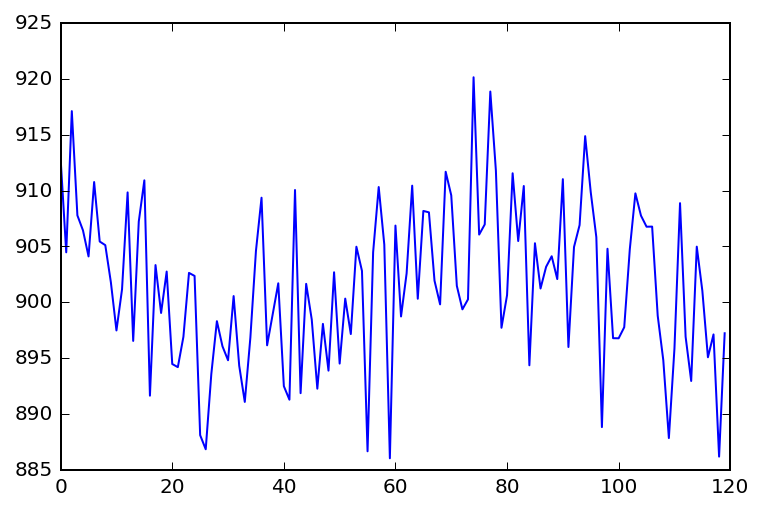

In [18]:
_ = plt.plot(data[:, 10, 34, 34])

### Breakout session:
> - Save all transverse slices for a sagittal and coronal axis (you can choose any number), in a variable called `transverse``

> - Make a plot for all transverse slices (different voxels are plotted in the same figure). Label the axis. What does this plot tell us?

> - Transpose the transverse variable and plot. Label the axis accordingly. What does this plot tell us?

[[   73.2839543    131.71758118   124.0734092  ...,  1347.66406539
    778.8893962     51.37137018]
 [   98.60495917   258.72881363   155.47306924 ...,  1364.53468756
    759.40877243    46.80750361]
 [   51.92109989   306.75120436   117.86980099 ...,  1330.41087898
    755.9023864     43.22149434]
 ..., 
 [   66.8333681    370.75184676   110.96223797 ...,  1345.31983099
    740.83370107    71.13858928]
 [   60.58526683   206.06859764   129.01928773 ...,  1353.84205612
    797.33889258    69.98402629]
 [   85.3323014    242.3965068    139.0734092  ...,  1345.36985052
    729.81832182    83.8073206 ]]


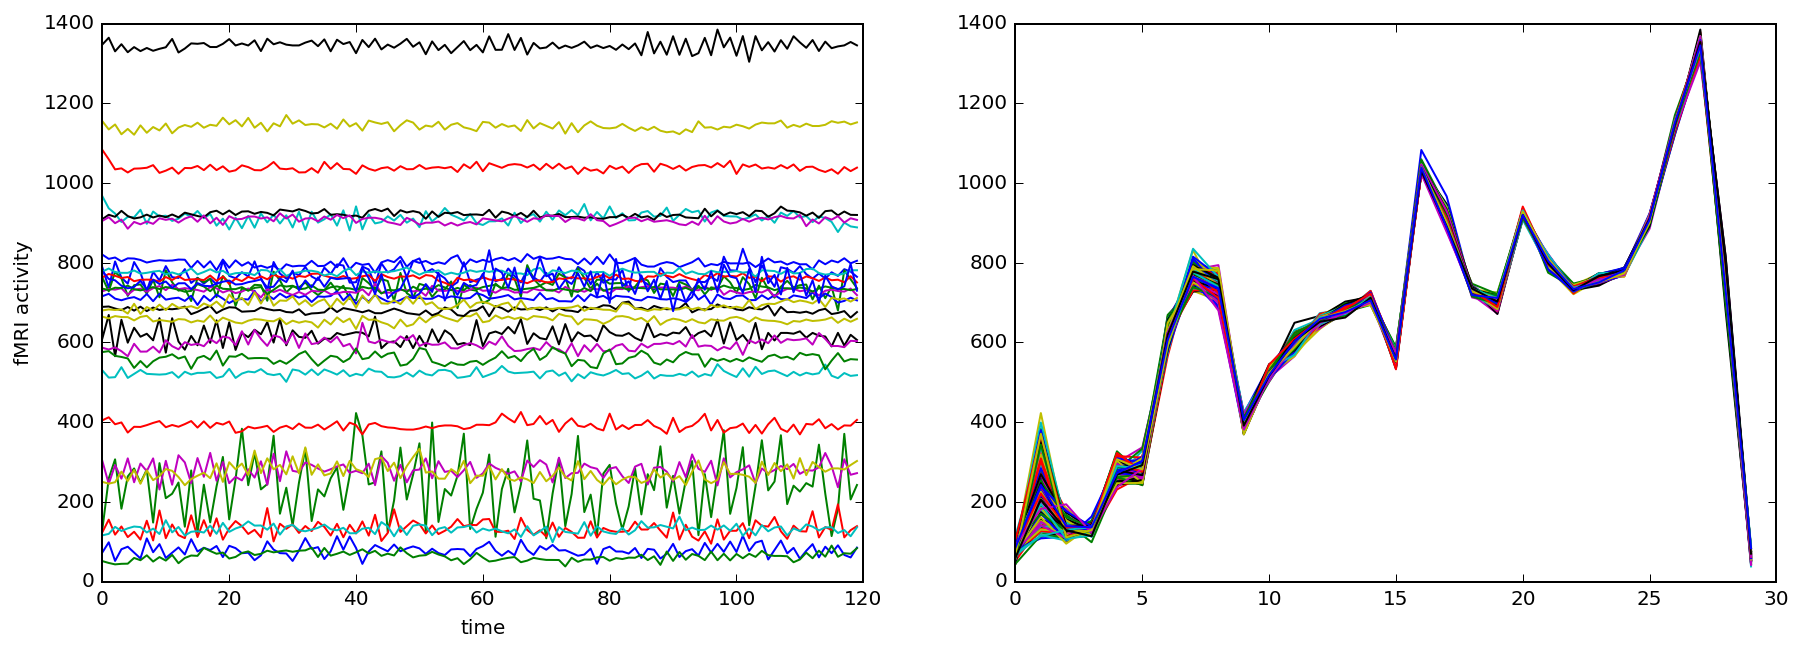

In [19]:
### STUDENT ANSWER
transverse = data[:, :, 45, 45]
print(transverse)

f, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(transverse);
axs[0].set_xlabel('time')
axs[0].set_ylabel('fMRI activity')

axs[1].plot(transverse.T);



Note that we have 30,000 measurements to plot like this. So we *could* make a plot like the eeg representations that we had, but those were pretty busy even with 60 lines. So, instead, we will view our data as images.

## Displaying data as an image

First, we will get a broader view of the first volume of our data. The (T, Z, Y, X) dimension ordering that we have for the data makes it easy to select volumes (time snapshots of brain activity).

Below are some ways to select volumes:

In [20]:
# We can select one volume like this: 
first_volume = data[0, :, :, :]

# Or like this: 
alt_first_volume1 = data[0, ...]

# Or like this: 
alt_first_volume2 = data[0]

# These are all the same1
assert np.all(first_volume==alt_first_volume1)
assert np.all(first_volume==alt_first_volume2)

In [21]:
print(first_volume.shape)

(30, 100, 100)


### Visualizing the horizontal slice
Let's look at an example of a horizontal slice from the first volume. This can be done by selecting one of the slices as follows:

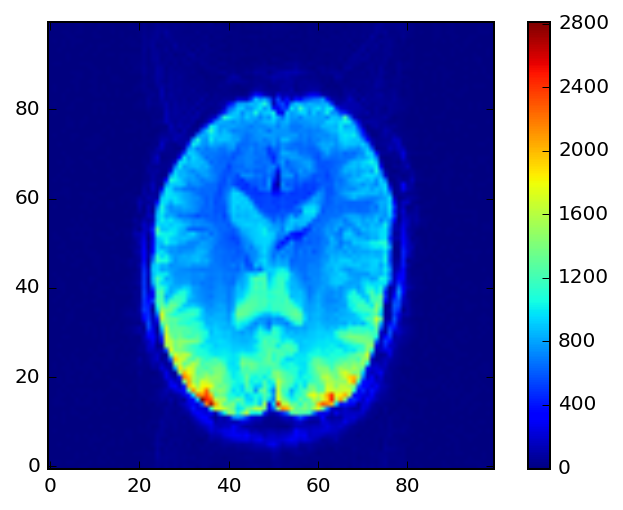

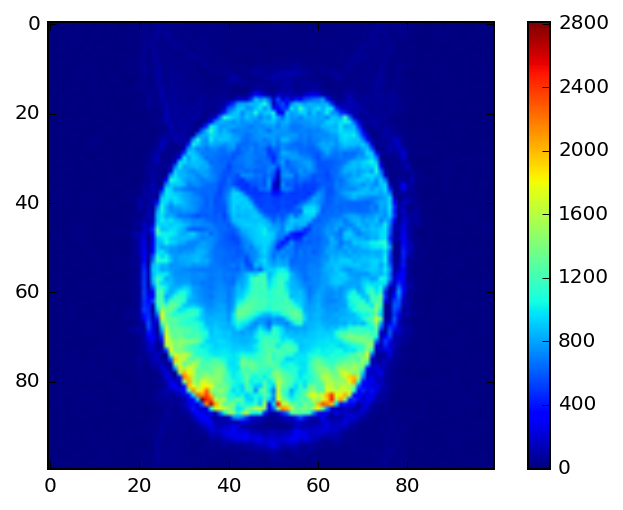

In [23]:
# Z=15 is halfway through the volume we have scanned
slice_horizontal = first_volume[15,:,:]

# You can set the image origin [0,0] to be in the upper left corner
# by using origin='upper'
plt.figure()
im = plt.imshow(slice_horizontal, origin='lower') 
_ = plt.colorbar(im)

# Alternative:
plt.figure()
im = plt.imshow(slice_horizontal[::-1]) 
_ = plt.colorbar(im)

### Breakout session:
> - Plot other slices to see how the shape of the brain is different
> - Change the properties of the figure. Explore the keyword arguments for imshow, see what each does! (hints: show axes, change colormap, what about vmin and vmax values, set those)

Link to blog post about colormaps!

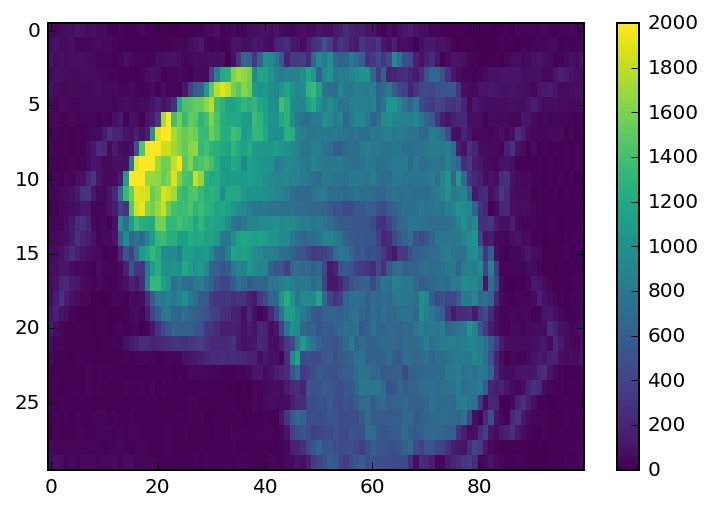

In [25]:
### STUDENT ANSWER
slice_example = first_volume[:,:,50]

im = plt.imshow(slice_example[::-1], islation='nearest', aspect='auto', cmap='viridis', vmin=0, vmax=2000)
_ = plt.colorbar(im)

In [ ]:
### TEACHER INFO


### Breakout session:
> Write a small helper function that takes a slice number as an input returns the data (2D array) of that slice
> Plot this image

In [ ]:
### STUDENT ANSWER


### Breakout session: Visualizing sagittal and coronal views
We can also slice the brain on different axis to obtain sagittal and coronal slices. 

> Try to plot these below. We have not told you which dimension corresponds to slicing the brain in a sagittal or coronal view. You should try the different axes and find it out.

In [ ]:
# Select a sagittal slice and plot
### STUDENT ANSWER


In [ ]:
# Select a coronal slice and plot
### STUDENT ANSWER


### Changing matplotlib default parameters

You can set the default colormap, default interpolation or many other parameters in `matplotlib.rcParams`.

For example to set all the colormaps in this `ipython` session to the colormap 'viridis' we can use the following line:
    * `matplotlib.rcParams['image.cmap'] = 'viridis'` # or whatever your favorite map is

In [ ]:
import matplotlib
matplotlib.rcParams['image.cmap'] = 'viridis' # or whatever your favorite map is e.g. 'gray', 'hot'
matplotlib.rcParams['image.interpolation'] = 'nearest'
# matplotlib.rcParams['image.aspect'] = 'auto'

An alternative way to change a figure's properties is to create a dictionary of keywords that can be used as a  keyword argument to the `imshow` function.

This has the advantage of not setting the default parameters. Yet, we can easily change a number of parameters in the `imshow` function by just passing the keywords dictionary to the `imhsow` function. The following cell is demonstrating this:

In [ ]:
im_kws = dict(aspect='auto', vmin=0, vmax=2000, cmap='hot', interpolation='nearest') 
plt.imshow(first_volume[:,  30, :], **im_kws)
plt.colorbar()

### Plot all horizontal slices

Let's try to make a plot with all of the horizontal slices, so we can see one entire 3D volume at once. For this, we will use the `subplot()` function in matplotlib:

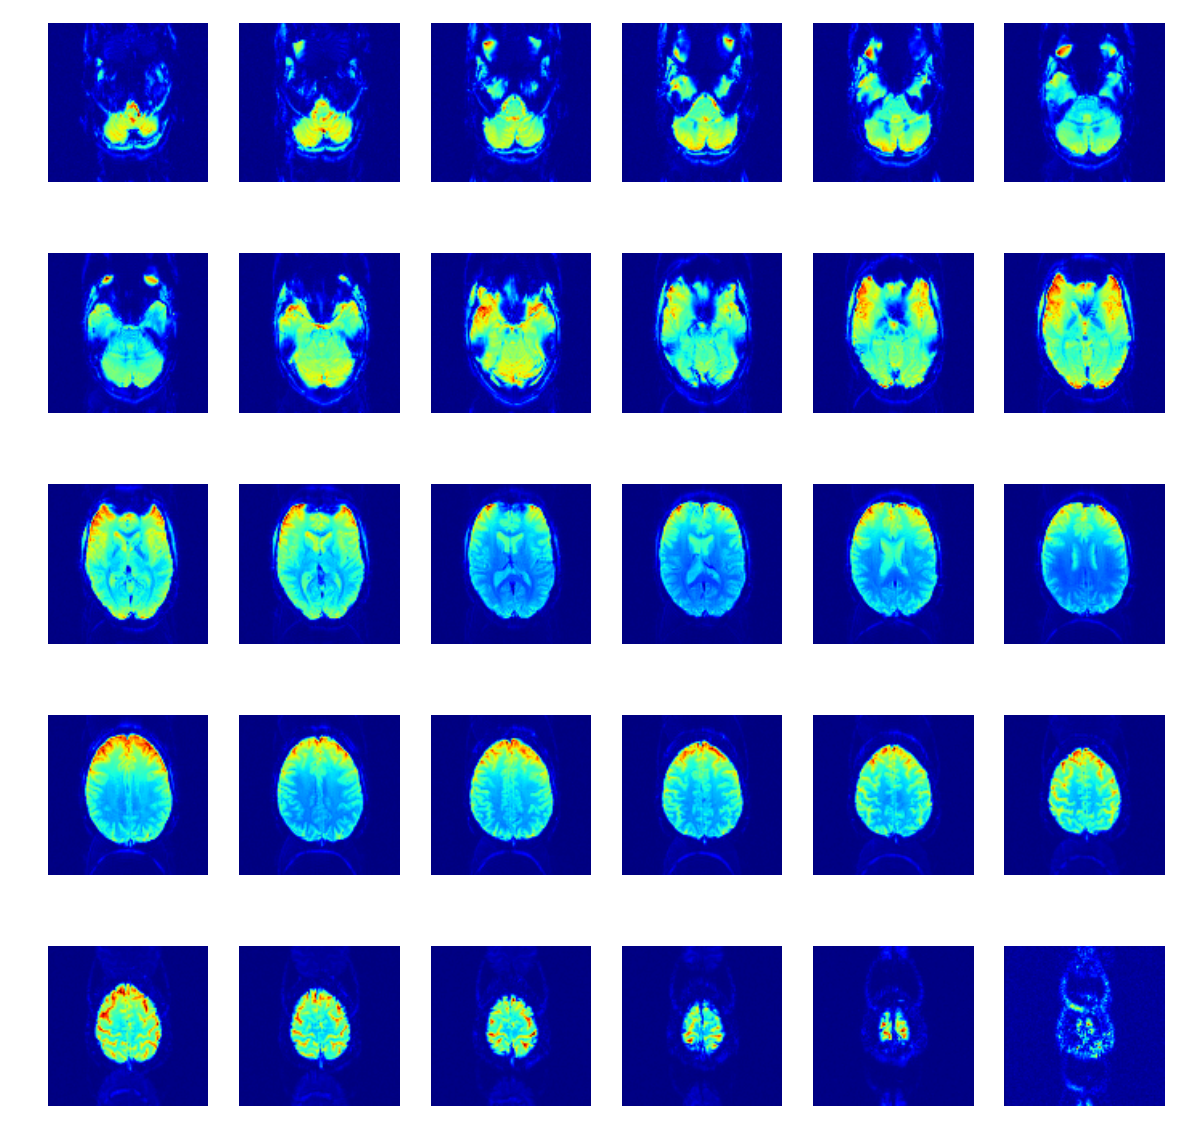

In [26]:
fig = plt.figure(figsize = (10,10))
n_slices = 30
nrows, ncols = 5, 6
for s in range(n_slices):
    ax = fig.add_subplot(nrows, ncols, s+1)
    slice_horizontal = first_volume[s,:,:]
    plt.imshow(slice_horizontal)
    ax.axis('off')

Now let's make a function that plots the above:

In [27]:
def plot_horizontal_slices(vol, **kwargs):
    fig = plt.figure(figsize=(10,10))
    nslices = vol.shape[0]
    subplot_size = np.ceil(np.sqrt(nslices))
    for s in range(nslices):
        ax = fig.add_subplot(subplot_size, subplot_size, s+1) 
        slice_horizontal = vol[s,:,:]
        plt.imshow(slice_horizontal, **kwargs)
        ax.axis('off')

### Breakout session:
> Call the above function (plot_horizontal_slices), and try out different plotting arguments (e.g. change the colormap, change the interpolation, etc.):

In [ ]:
### STUDENT CELL

## Masking

You may have noticed in the figure above that many of the voxels do not overlap with the brain (or more specifically the gray matter in the cortex) at all. Actually, let's try to plot some of those voxels:

In [ ]:
plt.plot(data[:,0,0,0], label='Edges of volume, 1')
plt.plot(data[:,1,1,1], label='Edges of volume, 2')
plt.plot(data[:,-1,-1,-1], label='Edges of volume, 3')

# A middle brain voxel
plt.plot(data[:,10,34,34], label='Mid brain')
plt.legend(loc='best')

The edge-of-scan voxels are clearly not in the brain, however, they show some variance due to noise. It is the practice in fMRI to mask out, or zero out these voxels.

A mask is a 3D binary array that is derived from the high resolution anatomical scan of the subject. The mask indicates, for every voxel in the 30 x 100 x 100 matrix, which ones should be ignored and which should be kept. Let's load and look at a voxel mask for this subject:

In [ ]:
# Load a stored mask for this subject
#fname = '../../data/fMRI/categories/s01_category_mask_cortical.npz'
fname = '/home/shared/cogneuro-connector/data/fmri/categories/s01_category_mask_cortical.npz'
mask = np.load(fname)['mask']
print('Mask shape: ', mask.shape)
print(mask[10,:,:])

Let's plot one fo the slices below:

In [ ]:
mask_horizontal = mask[15,:,:]
plt.imshow(mask_horizontal, origin='upper', cmap='gray')
_ = plt.axis("off")

We can see that the mask clearly indicates which voxels should be kept. 

### Breakout session: 
> Let's look at the 3D structure. Use the function we defined above to plot the entire 3D mask:

In [ ]:
### STUDENT ANSWER


You can see how now we have a mask that indicates which voxels we should keep and which we should exclude.

We can use the mask to set the tiny values outside the brain, and the values in the middle of the brain (in subcortical stuctures) to zero:

In [ ]:
# Let's plot the horizonral slices for the first volume
plot_horizontal_slices(first_volume)

In [ ]:
masked_vol_0 = first_volume * mask

# Now plot masked_vol_0:
plot_horizontal_slices(masked_vol_0)

You can see that the voxels outside the cortex (including in the middle of the brain) are zeroed out now! Let's apply this mask to the entire dataset now and zero out the same voxels in each volume:

In [ ]:
# First create an array with zeros
print(data.shape)
masked_data = np.zeros_like(data)

# NOTE: np.zeros_like is similar to creating an array using np.zeros. We can check this by:
assert np.all(np.zeros(data.shape)==np.zeros_like(data)) 

# Not run through the entire data set and mask each volume
for i in range(data.shape[0]):
    masked_data[i,:,:,:] = data[i,:,:,:] * mask

### Quick example for list comprehension

We can replace the above foor loop using list comprehension.

In general, list comprehension can be used to tranform a list to another list. During this process in the new list elements of the old list can be modified. List comprehensions can be used to replace many lines of code to a more compact one line. Every list comprehension can be written as a for loop. The opposite is not necessarly true.

We can basically use the same masking operation from the cell above and replace it by list comprehension. Let's see first how list comprehension works in a simple example:

In [ ]:
x = np.arange(5)
print('Input list: {}'.format(x))

# Let's create a for loop that squares each element in this list
# Afterwards, do the same using list comprehension 
# Compare the resulting arrays

### TEACHER INFO


Now we can use list comprehension to create the masked_data in a neat way:

In [ ]:
# Take individual volumes from data along the first dimension, and multiplies them by the mask
masked_data_v1 = [d*mask for d in data]  
print('masked_data_v1 is a {0} of size {1}'.format(type(masked_data_v1), len(masked_data_v1)))
print('each element is a {0} of size {1}'.format(type(masked_data_v1[0]), masked_data_v1[0].shape))
print('Type: {}, Shape: {}'.format(type(masked_data_v1), np.shape(masked_data_v1)))

Now let's try to combine them into an array, this is done as follows, and results in a 4 dimensional array. This stacks the data such as the first dimension is the one that is defined by the list:

In [ ]:
masked_data_v2 = np.array([d*mask for d in data])

print('masked_data_v2 is a {0} of size {1}'.format(type(masked_data_v2), masked_data_v2.shape))
print('each element is a {0} of size {1}'.format(type(masked_data_v2[0]), masked_data_v2[0].shape))
print('Type: {}, Shape: {}'.format(type(masked_data_v2), np.shape(masked_data_v2)))

### Breakout session:

> Now try plotting other volumes from masked_data_v2

In [ ]:
### STUDENT ANSWER


#### Logical indexing on the data array
You can see that there are many voxels that do not contain interesting information. Instead of storing each volume as a 3D array, we can instead take only the voxels that are in the mask.

We can use logical indexing to do this. Logical indexing can be used on any array:

In [ ]:
a = np.array([1, 2, 3, 4, 5])
idx = np.array([True, False, True, False, False])

In [ ]:
print(a[idx])

In [ ]:
# More examples: 2D
a = np.arange(20).reshape(5,4)
print(a)
idx = np.array([False, True, False, True])

In [ ]:
print(a[:, idx])

In [ ]:
first_volume = data[0]
print('shape of first_volume is {}'.format(first_volume.shape))

first_volume_masked = first_volume[mask==True]  # we can omit ==True, because mask is already a boolean array
print('shape of first_volume_masked is {}'.format(first_volume_masked.shape))

In [ ]:
_ = plt.hist(first_volume_masked.flatten(), 50)

Now we can compress the entire matrix:

In [ ]:
masked_data_v3 = data[:, mask]

print('masked_data_v3 is a {0} of size {1}'.format(type(masked_data_v3), masked_data_v3.shape))
print('each element is a {0} of size {1}'.format(type(masked_data_v3[0]), masked_data_v3[0].shape))

If we make another histogram of the masked (collapsed) data, we can see that we have a more interesting range of values left:

In [ ]:
_ = plt.hist(masked_data_v3.flatten(), 50)

We can easily go back and forth between the two formats, we need to have the mask and the 2D matrix to produce the 4D matrix:

In [ ]:
unmasked_data = np.zeros(data.shape)
unmasked_data[:, mask] = masked_data_v3 

print('unmasked_data is a {0} of size {1}'.format(type(unmasked_data), unmasked_data.shape))
print('each element is a {0} of size {1}'.format(type(unmasked_data[0]), unmasked_data[0].shape))

In [ ]:
_ = plt.hist(unmasked_data.flatten(), 50)


## Time series

Remember that one of these volumes is acquired at every time unit. The time unit here is 2.0045 seconds. Let's look at one slice at different time points. Now because masked_data_v3 only has cortical voxels, we can plot any of its dimension knowing that we are looking at gray matter.

In [ ]:
masked_data_v3.shape

### Breakout session: 
> Try to plot the activity in time for different voxels. What do you notice?

In [ ]:
### TEACHER INFO


Let's plot four different voxels time series

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(time_points, masked_data_v3[:n_points, 4].T)
plt.plot(time_points, masked_data_v3[:n_points, 10].T)
plt.plot(time_points, masked_data_v3[:n_points, 100].T)
plt.plot(time_points, masked_data_v3[:n_points, 1000].T)

_ = plt.xlabel("Time (s)")
_ = plt.ylabel("fMRI activity")

The voxels seem to have a different baseline! (You might have suspected this based on the image plots or the histogram plots above, too).

Let's plot one slice at different time points:

In [ ]:
fig = plt.figure(figsize = (10,10))
z_slice = 10
for s in range(15):
    ax = fig.add_subplot(5, 5, s+1)
    slice_horizontal = data[s, z_slice, :, :]
    slice_horizontal[~mask[z_slice, : , :]] = 0
    plt.imshow(slice_horizontal)
    plt.title('TR #{n}'.format(n=s+1))
    ax.axis('off')

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.imshow(masked_data_v3, aspect='auto')
# Set the axis labels using the `setp` method.
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.setp
plt.setp(ax, xlabel='Voxels', ylabel='Time')

### Normalize the activity at each voxel (zscore across time)

You can see the same effect in the time plots as well as in the mosaic plots: some voxels have a different baseline than others. 

We need to normalize the activity of each voxel in time to be able to see local fluctuations in the signal. This normalization is also called *z-score* or *standard score*.

1. We will first take the mean and standard deviation across time for each cortical voxel.
2. For each voxel, we will substract the mean from each time point.
3. For eacl voxel, we will divide each time point by the standard deviation.

In [ ]:
print(masked_data_v3.shape)
data_norm = masked_data_v3 - masked_data_v3.mean(axis = 0)
data_norm = data_norm / data_norm.std(axis = 0)

Now plot the time course:

In [ ]:
plt.figure(figsize = (10,5))
TR = 2.0045
points = range(0,100)
time_points = np.array(points)*TR

plt.plot(time_points, data_norm[:n_points, 4].T)
plt.plot(time_points, data_norm[:n_points, 10].T)
plt.plot(time_points, data_norm[:n_points, 100].T)
plt.plot(time_points, data_norm[:n_points, 1000].T)

_ = plt.xlabel("Time (s)")
_ = plt.ylabel("fMRI activity")

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.imshow(data_norm, aspect='auto') 
plt.setp(ax, xlabel='Voxels', ylabel='Time')

And plot the volumes in time:

In [ ]:
data_norm_unmasked = np.zeros_like(data)
data_norm_unmasked[:,mask] = data_norm

In [ ]:
fig = plt.figure(figsize = (10,10))
for s in range(15):
    ax = fig.add_subplot(5,5,s+1)
    slice_horizontal = data_norm_unmasked[s,10,:,:]
    slice_horizontal[~mask[10,:,:]] = 0
    plt.imshow(slice_horizontal, vmin=-3, vmax=3) # don't forget vmin / vmax!
    ax.axis('off')

---